In [ ]:
import os  # noqa
import sys  # noqa

proj_root = os.path.dirname(os.getcwd())
sys.path.append(proj_root)

OBJ_NAME = "mustard_bottle"
VIDEO_NAME = "mustard0"

video_dir = os.path.join(proj_root, "data", "inputs", VIDEO_NAME)
canonical_points_path = os.path.join(video_dir, "canonical_3d_points.npy")
query_points_path = os.path.join(video_dir, "query_points.npy")
tracker_result_video = os.path.join(video_dir, "tracker_result.mp4")
cam_K_dir = os.path.join(video_dir, "cam_K.txt")
poses_dir = os.path.join(video_dir, "annotated_poses")
video_rgb_dir = os.path.join(video_dir, "rgb")
video_img_dir = os.path.join(video_dir, "img")
obj_dir = os.path.join(proj_root, "data", "objects", OBJ_NAME)
obj_path = os.path.join(obj_dir, "textured_simple.obj")
ply_path = os.path.join(obj_dir, "textured.ply")
texture_path = os.path.join(obj_dir, "texture_map.png")

/home/joao/miniconda3/envs/gspose/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


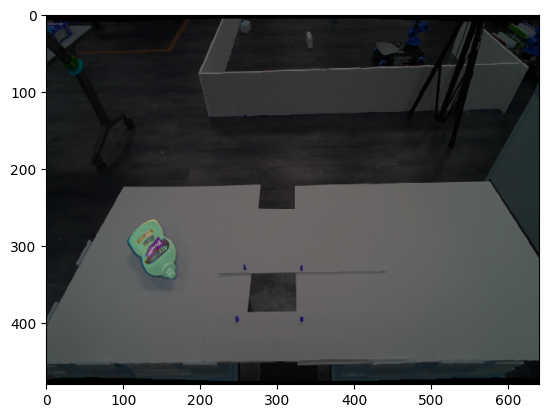

In [2]:
from posingpixels.utils.offscreen_renderer import ModelRendererOffscreen, cvcam_in_glcam
import cv2
import numpy as np
import trimesh
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
import trimesh

from posingpixels.utils.meshes import get_diameter_from_mesh
from posingpixels.alignment import get_safe_query_points
import mediapy
import numpy as np
from scipy.spatial.transform import Rotation as R
from scipy.spatial.transform import Slerp
import ffmpeg


K = np.loadtxt(cam_K_dir).reshape(3, 3)
rgb = cv2.imread(os.path.join(video_rgb_dir, "1581120424100262102.png"), cv2.IMREAD_COLOR)
pose = np.loadtxt(os.path.join(poses_dir, "0000000.txt")).reshape(4, 4)
H, W = rgb.shape[:2]
model_renderer = ModelRendererOffscreen(K, H, W)
mesh: trimesh.Trimesh = trimesh.load_mesh(obj_path)
rgb_render, depth_render = model_renderer.render(
    mesh, ob_in_cvcam=pose
)

overlay = cv2.addWeighted(rgb, 0.5, rgb_render, 0.5, 0)

plt.imshow(overlay)
plt.show()

0.19646325799497472


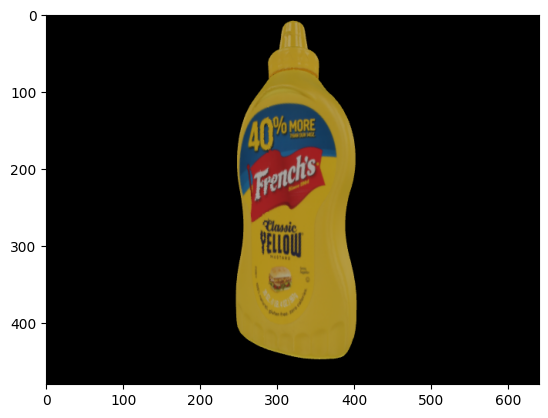

In [3]:
pose_base = np.eye(4)
diameter = get_diameter_from_mesh(mesh)
print(diameter)
# Rotate 90 degrees around x-axis then rotate around y-axis 180 degrees
pose_base[:3, :3] = np.array([[1, 0, 0], [0, 0, -1], [0, 1, 0]])
pose_base[:3, :3] = np.array([[-1, 0, 0], [0, 1, 0], [0, 0, -1]]) @ pose_base[:3, :3]
pose_base[:3, 3] = np.array([0, 0, diameter])
rgb_render, depth_render = model_renderer.render(
    mesh, ob_in_cvcam=pose_base
)

plt.imshow(rgb_render)
plt.show()

In [4]:


unposed_3d_points, query_2d_points = get_safe_query_points(
    R = pose_base[:3, :3],
    T = pose_base[:3, 3],
    camK = K,
    H = H,
    W = W,
    mesh = mesh,
)
# Save unposed_3d_points and query_2d_points as npy files
np.save(canonical_points_path, unposed_3d_points)
np.save(query_points_path, query_2d_points)
print(query_2d_points.shape)
print(query_2d_points[:5, :])

(71, 3)
[[  0. 321.  37.]
 [  0. 313.  62.]
 [  0. 337.  70.]
 [  0. 304.  86.]
 [  0. 328.  94.]]


In [5]:
def interpolate_poses_builtin(R_start, T_start, R_end, T_end, num_steps):
    """Interpolate between initial (R_start, T_start) and final (R_end, T_end) poses using built-in functions."""
    # Convert rotation matrices to `Rotation` objects
    rot_start = R.from_matrix(R_start)
    rot_end = R.from_matrix(R_end)

    # Generate a series of fractional steps from 0 to 1
    fractions = np.linspace(0, 1, num_steps)

    # Interpolate rotation using built-in SLERP
    slerp = Slerp([0, 1], R.from_quat([rot_start.as_quat(), rot_end.as_quat()]))
    rotations = slerp(fractions)

    # Interpolate translation using LERP
    translations = np.array([T_start + f * (T_end - T_start) for f in fractions])

    # Combine rotations and translations into poses
    interpolated_poses = [(rotations[i].as_matrix(), translations[i]) for i in range(num_steps)]

    return interpolated_poses

num_steps = 15
interpolated_poses = interpolate_poses_builtin(pose_base[:3, :3], pose_base[:3, 3], pose[:3, :3], pose[:3, 3], num_steps)

# Check that video_img_dir exists, if not create it
if not os.path.exists(video_img_dir):
    os.makedirs(video_img_dir)
# Check that video_img_dir is empty, if not delete its contents
for f in os.listdir(video_img_dir):
    os.remove(os.path.join(video_img_dir, f))
# Copy contents from video_rgb_dir (.png) to video_img_dir (.jpg) in order, but renamed with 5-digit numbers
for i, f in enumerate(sorted(os.listdir(video_rgb_dir))):
    img = cv2.imread(os.path.join(video_rgb_dir, f))
    cv2.imwrite(os.path.join(video_img_dir, f"{i + num_steps:05d}.jpg"), img)
# Print results
frames = []
# subprocess.run(["ffmpeg", "-i", object_video_path, "-q:v", "2", "-start_number", "0", f"{object_video_dir}/img/%05d.jpg"])
for i, (R_i, T_i) in enumerate(interpolated_poses):
    pose = np.eye(4)
    pose[:3, :3] = R_i
    pose[:3, 3] = T_i
    rgb_render, depth_render = model_renderer.render(
        mesh, ob_in_cvcam=pose
    )
    frames.append(rgb_render)
    cv2.imwrite(os.path.join(video_img_dir, f"{i:05d}.jpg"), cv2.cvtColor(rgb_render, cv2.COLOR_RGB2BGR))

mediapy.show_video(frames, fps=15)

In [6]:
from posingpixels.cotracker import get_online_cotracker_predictions


pred_tracks, pred_visibility, pred_confidence = get_online_cotracker_predictions(
    video_img_dir,
    grid_size=0,
    queries=query_2d_points,
)

Processing batches: 94it [00:20,  4.51it/s]                        


In [ ]:
from pathlib import Path
import cv2
import numpy as np
import torch
from concurrent.futures import ThreadPoolExecutor
from cotracker.utils.visualizer import Visualizer
import torch

# Collect and sort filenames
video_files = sorted(Path(video_img_dir).glob("*.jpg"))

# Function to read an image
def read_image(file_path):
    return cv2.cvtColor(cv2.imread(str(file_path)), cv2.COLOR_BGR2RGB)

# Parallel reading
with ThreadPoolExecutor() as executor:
    images = list(executor.map(read_image, video_files))

# Convert to a NumPy array
video_np = np.stack(images, axis=0)

# Convert to PyTorch tensor
video = torch.from_numpy(video_np).to(dtype=torch.uint8)

# video = torch.tensor([cv2.imread(os.path.join(video_img_dir, file)) for file in sorted(os.listdir(video_img_dir))[:10]], dtype=torch.uint8)
# print(video.shape)
# print(pred_tracks.shape)
# print(pred_visibility.shape)
# print(video.shape)
# vis = Visualizer(save_dir=tracker_result_video, pad_value=0, linewidth=3)
# vis.visualize(video, pred_tracks, pred_visibility)

In [27]:
tracker_result_video = os.path.join(video_dir)
print(video.shape)
vis = Visualizer(save_dir=tracker_result_video, pad_value=0, linewidth=3)
vis.visualize(video.permute(0, 3, 1, 2).unsqueeze(0), pred_tracks, pred_visibility * pred_confidence > 0.6)

torch.Size([752, 480, 640, 3])
Video saved to /home/joao/Documents/repositories/GSPose/data/inputs/mustard0/video.mp4


tensor([[[[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],

          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],

          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]],


         [[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],

          [[0, 0, 0,  ..., 0, 0, 0],
 